This is an implementation of the artistic neural network as described in this [paper](https://arxiv.org/abs/1508.06576). VGG pretrained model weights can be downloaded from [here](http://www.vlfeat.org/matconvnet/models/). Use imagenet-vgg-verydeep-19.mat and imagenet-vgg-verydeep-16.mat

In [17]:
from __future__ import print_function
import os
import gc
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import scipy.io
import PIL.Image
import cPickle as pickle
from IPython.display import clear_output, Image, display
from io import BytesIO

In [18]:
class VGG(object):
    
    def __init__(self, path):
        self.content_layer = None
        self.style_layer = None
        self.path = path
        self.weights = scipy.io.loadmat(self.path)['layers']
    
    def create_graph(self, input_shape):
        """
        The pretrained model contains the layer name and layer type (i.e. pool, conv etc.)
        To access those information, we can do the index access:
        vgg_layers[0]      [0]       [0]      [0]      [2]                                    [0]      [0] ## weight
        vgg_layers[0]      [0]       [0]      [0]      [2]                                    [0]      [1] ## bias
                  always 0 |layer idx|always 0|always 0|0:layer name; 1:layer type; 2: weights|always 0|0:weight; 1:bias
        vgg_layers[0][30][0][0][0][0] # to access layer name
        vgg_layers[0][30][0][0][1][0] # to access layer type
        
        Note that the fully connected layers and the softmax are not required for this task, therefore we will skip it. 
        The fully connected layers have name fc* (It's type is conv though).
        """
        if self.path == None:
            raise Exception("Run from the child class")
            
        vgg_layers = self.weights
        num_layers = len(vgg_layers[0])
        
        graph = {}
        layer_names = []
        graph["input"] = tf.Variable(np.zeros(input_shape), dtype=tf.float32)
        prev = "input"
        layer_names.append("input")
        
        for idx in range(num_layers):
            
            layer_name = vgg_layers[0][idx][0][0][0][0]
            layer_type = vgg_layers[0][idx][0][0][1][0]
            
            if layer_name[:2] == "fc":
                break                     # stop before adding the first fc layer
            
            layer_names.append(layer_name)
            
            if layer_type == "conv":
                W = vgg_layers[0][idx][0][0][2][0][0]
                b = vgg_layers[0][idx][0][0][2][0][1]
                W = tf.constant(W)        # we don't want to update the parameters
                b = tf.constant(np.reshape(b, (b.size)))
                graph[layer_name] = tf.nn.conv2d(graph[prev], filter=W, strides=[1, 1, 1, 1], padding="SAME") + b
            elif layer_type == "relu":
                graph[layer_name] = tf.nn.relu(graph[prev])
            elif layer_type == "pool":    # according to the paper, average pooling behaves better
                graph[layer_name] = tf.nn.avg_pool(graph[prev], ksize=[1, 2, 2, 1], 
                                                   strides=[1, 2, 2, 1], padding="SAME")
            else:
                raise Exception("Unknown layer")
            
            prev = layer_name
        return graph, layer_names
    
    def get_layer_names(self):
        return self.layer_names
    
    def get_instance(model_path, force=False):
        raise Exception("Do not instantiate this class")

In [19]:
class VGG19(VGG):
    
    instance = None
    
    def __init__(self, model_path):
        super(VGG19, self).__init__(model_path)
        self.content_layer = "conv4_2"
        self.style_layer = {
            "relu1_1": 1.0,
            "relu2_1": 1.0,
            "relu3_1": 1.0,
            "relu4_1": 1.0,
            "relu5_1": 1.0
        }
    
    def get_instance(model_path, force=False):
        """
        Singleton to avoid load graph on every run
        If force is True, then force reload
        """
        if VGG19.instance == None or force:
            VGG19.instance = VGG19(model_path)
        return VGG19.instance
    
    get_instance = staticmethod(get_instance)

In [20]:
class VGG16(VGG):
    
    instance = None
    
    def __init__(self, model_path):
        super(VGG16, self).__init__()
        self.graph = self.load_model()
        self.content_layer = "relu4_2"
        self.style_layer = {
            "relu1_2": 0.5,
            "relu2_2": 1.0,
            "relu3_3": 1.5,
            "relu4_3": 1.5,
            "relu5_3": 4.0
        }
    
    def get_instance(model_path, force=False):
        """
        Singleton to avoid load graph on every run
        If force is True, then force reload
        """
        if VGG16.instance == None or force:
            VGG16.instance = VGG16(model_path)
        return VGG16.instance
    
    get_instance = staticmethod(get_instance)

In [21]:
class VGGFactory(object):
    
    def factory(name, model_path, force=False):
        """
        The factory to create the corresponding model we will use
        Available names include "VGG16" and "VGG19"
        If force is set, then force reload the graph
        """
        if name == "VGG16": return VGG16.get_instance(model_path, force)
        if name == "VGG19": return VGG19.get_instance(model_path, force)
    
    factory = staticmethod(factory)

In [31]:
class MagicPen(object):
    """
    The actual class that carries out the image generation
    """
    
    # means for RGB channels. I believe it's the training set average for the pretrained model,
    # according to this: https://gist.github.com/ksimonyan/211839e770f7b538e2d8. Also various 
    # sources agree on those values.
    IMG_MEAN = np.array([103.939, 116.779, 123.68], dtype=np.float32) 
    RANDOM_RATE = 0.6
    
    def save(pen, file_name):
        pickle.dump(pen, open( file_name, "wb"))
        
    def load(file_name):
        pen = pickle.load(open(file_name, "rb"))
        return pen
    
    save = staticmethod(save)
    load = staticmethod(load)
    
    def __init__(self, vgg_name, vgg_path, style_path, alpha=None, beta=None, iterations=None):
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        print("Load graph")
        self.vgg = VGGFactory.factory(vgg_name, vgg_path)
        print("Precompute the gram matrices for style")
        self.style_loss_mat = self._style_mat(self._load_img(style_path), self.vgg.style_layer)
        print("OK")
        
    def _generate_base(self, content):
        """
        Add some noise to the content image to get the base image
        """
        random_img = np.random.uniform(-20, 20, content.shape)
        return MagicPen.RANDOM_RATE * random_img + content * (1 - MagicPen.RANDOM_RATE)
        
    def _load_img(self, image_path):
        """
        Returns the image with 4 dimensions
        """
        image = PIL.Image.open(image_path)
        image = np.float32(image)
        image -= MagicPen.IMG_MEAN
        image = np.reshape(image, ((1,) + image.shape))
        return image[:, :, :, ::-1] # flip to BGR
    
    def _style_mat(self, style_img, style_layers):
        graph, _ = self.vgg.create_graph(style_img.shape)
        grams = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            graph["input"].assign(style_img).eval()
            for key in style_layers:
                print(key)
                P = sess.run(graph[key])
                N = P.shape[3]  # number of filters
                M = P.shape[1] * P.shape[2] # hight x width of one feature map 
                A = self.gram_matrix(P, N, M).eval()
                grams.append((A, key, style_layers[key]))
        return grams
    
    def set_alpha(self, alpha):
        self.alpha = alpha
        return self
    
    def set_beta(self, beta):
        self.beta = beta
        return self
    
    def set_iters(self, iterations):
        self.iterations = iterations
        return self
    
    def load_content(self, image_path):
        self.content = self._load_img(image_path)
        self.base = self._generate_base(self.content)
        return self
    
    def gram_matrix(self, F, N, M):
        """
        The gram matrix G.
        F -- the features
        N -- number of filters
        M -- hight x width of one feature map 
        Names as per paper
        """
        G = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(G), G)
    
    def content_loss(self, sess, graph):
        """
        Compute the context loss as described in the paper. We only need to do the forward 
        pass once on the content image
        
        sess -- the current session
        content_img -- the content image. should be a numpy array with dimension [1, hight, width, 3]
        Note: the dimension of the image should match with the one set at resize_input.
        Also, the image should be centered. The mean should be the training set mean of the VGG network.
        """
        graph["input"].assign(self.content).eval()
        P = sess.run(graph[self.vgg.content_layer])
        F = graph[self.vgg.content_layer]
        N = P.shape[3]  # number of filters
        M = P.shape[1] * P.shape[2] # hight x width of one feature map 
        return 0.5 * tf.reduce_sum(tf.pow(F - P, 2))
        
    
    def style_loss(self, graph):
        """
        Compute the style loss as described in the papaer. Again, only do forward pass once for style image
        
        sess -- the current session
        sytle_image -- the style image. Should be a numpy array. 4 dimentions
        Note: the style image should also have the same dimension as the content image, either by cropping or 
        some other methods.
        
        The style layers will contain multiple layers. Should be a dictionary with keys are the layer name, 
        and values are the associated weight
        """
        loss = []
        
        for A, key, w in self.style_loss_mat:
            F = graph[key]
            print(F)
            N = F.shape[3].value  # number of filters
            M = (F.shape[1] * F.shape[2]).value # hight x width of one feature map 
            G = tf.reshape(F, [M, N])
            G = tf.matmul(tf.transpose(G), G)
            A = tf.convert_to_tensor(A)
            loss.append((1.0 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2)) * w)
            
        return sum(loss)
    
    def sum_total_variation_losses(self, graph):
        b, h, w, d = self.content.shape
        x = graph["input"]
        tv_y_size = b * (h-1) * w * d
        tv_x_size = b * h * (w-1) * d
        loss_y = tf.nn.l2_loss(x[:,1:,:,:] - x[:,:-1,:,:]) 
        loss_y /= tv_y_size
        loss_x = tf.nn.l2_loss(x[:,:,1:,:] - x[:,:,:-1,:]) 
        loss_x /= tv_x_size
        loss = 2 * (loss_y + loss_x)
        loss = tf.cast(loss, tf.float32)
        return loss
    
    def draw(self):
        """
        The function to finally generate the image
        """
        print("shape is", self.content.shape)
        graph, _ = self.vgg.create_graph(self.content.shape)
        image = None
        
        with tf.Session() as sess:
            print("initialize variables")
            sess.run(tf.global_variables_initializer())
            print("compute content loss")
            content_loss = self.content_loss(sess, graph) * self.alpha
            print("compute style loss")
            style_loss   = self.style_loss(graph) * self.beta
            print("compute total loss")
            tv_loss      = self.sum_total_variation_losses(graph) * 1000.0
            print("total variational loss")
            total_loss   = content_loss + style_loss + tv_loss
            
            train_step   = tf.train.AdamOptimizer(2.0).minimize(total_loss)
            
            print("reinitialize the variables")
            sess.run(tf.global_variables_initializer())
            graph["input"].assign(self.base).eval()
            
#             print("iterative update starts")
#             for i in range(self.iterations):
#                 sess.run(train_step)
#                 if (i + 1) % 10 == 0:
#                     print(".", end=" ")
#                 if (i + 1) % 100 == 0:
#                     c_loss = content_loss.eval()
#                     s_loss = style_loss.eval()
#                     v_loss = tv_loss.eval()
#                     t_loss = total_loss.eval()
#                     print()
#                     print("%f, %f, %f, %f" % (c_loss, s_loss, v_loss, t_loss))
                
#             image = graph["input"].eval()
            
            optimizer = tf.contrib.opt.ScipyOptimizerInterface(total_loss, method='L-BFGS-B',
                                                              options={'maxiter': self.iterations,
                                                                          'disp': 1})
            optimizer.minimize(sess)
        
        tf.reset_default_graph()
        
        image = image[:, :, :, ::-1]
        image += MagicPen.IMG_MEAN
        
        return image

In [32]:
try:
    del pen
except NameError:
    print("pen is not defined")
else:
    gc.collect()

In [33]:
pen = MagicPen("VGG19", "models/imagenet-vgg-verydeep-19.mat", "starry_night.jpg")

Load graph
Precompute the gram matrices for style
relu1_1
relu5_1
relu4_1
relu3_1
relu2_1
OK


In [34]:
image = pen.load_content("tubingen.png").set_alpha(0.025).set_beta(5.0).set_iters(300).draw()

shape is (1, 384, 512, 3)
initialize variables
compute content loss
compute style loss
Tensor("Relu_16:0", shape=(1, 384, 512, 64), dtype=float32)
Tensor("Relu_28:0", shape=(1, 24, 32, 512), dtype=float32)
Tensor("Relu_24:0", shape=(1, 48, 64, 512), dtype=float32)
Tensor("Relu_20:0", shape=(1, 96, 128, 256), dtype=float32)
Tensor("Relu_18:0", shape=(1, 192, 256, 128), dtype=float32)
compute total loss
total variational loss
reinitialize the variables
iterative update starts
. . . . . . . . . . 
23390025728.000000, 11300889600.000000, 5267812.500000, 34696179712.000000
. . . . . . . . . . 
21960081408.000000, 6327757312.000000, 7311499.000000, 28295143424.000000
. . . . . . . . . . 
21160802304.000000, 4852364288.000000, 8909480.000000, 26022074368.000000


In [35]:
def showarray(a, fmt='jpeg'):
    """
    lol, copied from tf deep dream tutorial
    """
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

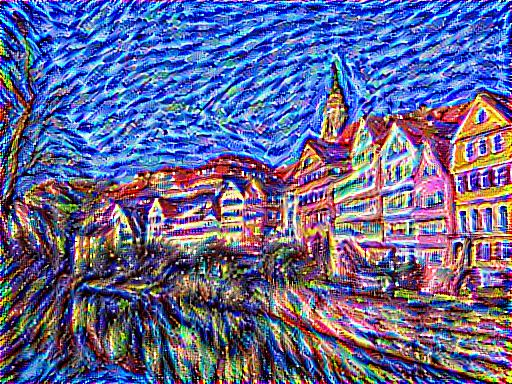

In [36]:
converted_image = np.clip((image[0]), 0, 255).astype('uint8')
showarray(converted_image/255.0)